# UltraLeap import playground



In [1]:
# Import public packages and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress


import openpyxl
from datetime import datetime
from scipy.spatial import distance
#from scipy import signal
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.api as sm
import statistics as stat


In [2]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)
    
    return path

In [3]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')

In [4]:
os.chdir(code_path)
# Import own functions
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info

import sig_processing.segment_tasks as tasks

import movement_calc.calc_3d_distances as calc_3d
import movement_calc.helpfunctions as hp

### Functions iterating over subject files

In [8]:
with open(
    'C:\\Users\\madal\\OneDrive - Charité - Universitätsmedizin Berlin\\Ultraleap-hand-tracking\\data\\Patientdata\\ul003\\desktop\\ul003_m1s1_desktop_ft\\ul003_m1s1_desktop_ft_lh.csv',
    'r') as file:
    lines = file.readlines()
    for line in lines:
        # print(line)
        if '.' in line:
            dat = pd.read_csv('C:\\Users\\madal\\OneDrive - Charité - Universitätsmedizin Berlin\\Ultraleap-hand-tracking\\data\\Patientdata\\ul003\\desktop\\ul003_m1s1_desktop_ft\\ul003_m1s1_desktop_ft_lh.csv')
            dat = import_dat.remove_double_and_onlyNan_rows(dat)
            break
        # else:
        #     print('nada')        


In [10]:
dat

,global_time,program_time,delta_time,thumb_metacarp_x,thumb_metacarp_y,thumb_metacarp_z,thumb_interphal_prox_x,thumb_interphal_prox_y,thumb_interphal_prox_z,thumb_interphal_dist_x,...,pinch_position_y,pinch_position_z,pinch_pred_position_x,pinch_pred_position_y,pinch_pred_position_z,is_pinching,pinch_strength,pinch_distance,grab_strength,confidence
0,11:33:06:3430,106.0251,0.0052,-0.1848,0.1425,-0.0807,-0.1400,0.1571,-0.0691,-0.1150,...,0.1565,-0.0397,-0.1009,0.1518,-0.0452,0.0,0.5392,38.1368,0.09,1.0
1,11:33:06:3548,106.0369,0.0041,-0.1856,0.1471,-0.0797,-0.1404,0.1609,-0.0671,-0.1152,...,0.1606,-0.0385,-0.1020,0.1568,-0.0427,0.0,0.5083,38.0005,0.12,1.0
2,11:33:06:3729,106.0550,0.0034,-0.1865,0.1522,-0.0784,-0.1409,0.1656,-0.0654,-0.1154,...,0.1653,-0.0371,-0.1021,0.1615,-0.0409,0.0,0.5076,38.1950,0.08,1.0
3,11:33:06:3741,106.0562,0.0029,-0.1865,0.1522,-0.0784,-0.1409,0.1656,-0.0654,-0.1154,...,0.1653,-0.0371,-0.1021,0.1615,-0.0409,0.0,0.5076,38.1952,0.08,1.0
4,11:33:06:3847,106.0668,0.0036,-0.1865,0.1522,-0.0784,-0.1409,0.1656,-0.0654,-0.1154,...,0.1653,-0.0371,-0.1021,0.1615,-0.0409,0.0,0.5076,38.1950,0.08,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10741,11:34:06:7198,166.4019,0.0028,-0.1418,0.2128,-0.0753,-0.1016,0.2411,-0.0636,-0.0779,...,0.2464,-0.0410,-0.0734,0.2499,-0.0375,1.0,0.8692,17.4172,1.00,1.0
10742,11:34:06:7350,166.4171,0.0030,-0.1418,0.2128,-0.0753,-0.1016,0.2411,-0.0636,-0.0779,...,0.2464,-0.0410,-0.0734,0.2499,-0.0375,1.0,0.8693,17.4191,1.00,1.0
10743,11:34:06:7471,166.4292,0.0026,-0.1418,0.2128,-0.0753,-0.1016,0.2411,-0.0635,-0.0779,...,0.2464,-0.0410,-0.0734,0.2499,-0.0374,1.0,0.8709,17.4013,1.00,1.0
10744,11:34:06:7592,166.4413,0.0058,-0.1418,0.2128,-0.0753,-0.1016,0.2411,-0.0635,-0.0779,...,0.2464,-0.0410,-0.0734,0.2499,-0.0374,1.0,0.8709,17.4012,1.00,1.0


In [15]:
data = import_dat.import_string_data('C:\\Users\\madal\\OneDrive - Charité - Universitätsmedizin Berlin\\Ultraleap-hand-tracking\\data\\Patientdata\\ul007\\desktop\\ul007_m1s0_desktop_ft\\ul007_m1s0_desktop_ft_lh.csv')
data = import_dat.remove_double_and_onlyNan_rows(data)


ValueError: 77 columns passed, passed data had 38 columns

In [13]:
data

,global_time,program_time,delta_time,thumb_metacarp_x,thumb_metacarp_y,thumb_metacarp_z,thumb_interphal_prox_x,thumb_interphal_prox_y,thumb_interphal_prox_z,thumb_interphal_dist_x,...,pinch_position_y,pinch_position_z,pinch_pred_position_x,pinch_pred_position_y,pinch_pred_position_z,is_pinching,pinch_strength,pinch_distance,grab_strength,confidence
0,09:56:53:6960,30.8801,0.0010,-0.1808,0.1629,-0.1650,-0.1485,0.1764,-0.1368,-0.1311,...,0.1727,-0.0890,-0.1202,0.1651,-0.0958,4055.0,0.0,3825.37,0.0,1.0
1,09:56:53:6970,30.8811,0.0009,-0.1808,0.1629,-0.1650,-0.1485,0.1764,-0.1368,-0.1311,...,0.1727,-0.0890,-0.1202,0.1651,-0.0958,4056.0,0.0,3825.37,0.0,1.0
2,09:56:53:7043,30.8884,0.0009,-0.1808,0.1629,-0.1650,-0.1485,0.1764,-0.1368,-0.1311,...,0.1727,-0.0890,-0.1202,0.1651,-0.0958,4055.0,0.0,3825.37,0.0,1.0
3,09:56:53:7079,30.8920,0.0017,-0.1806,0.1745,-0.1616,-0.1475,0.1876,-0.1322,-0.1295,...,0.1858,-0.0847,-0.1194,0.1806,-0.0913,1416.0,0.0,4691.36,0.0,1.0
4,09:56:53:7124,30.8965,0.0010,-0.1806,0.1745,-0.1616,-0.1475,0.1876,-0.1322,-0.1295,...,0.1858,-0.0847,-0.1194,0.1806,-0.0913,1415.0,0.0,4691.36,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13738,09:58:16:2552,113.4392,0.0009,-0.1709,0.0704,-0.2953,-0.1271,0.0750,-0.2779,-0.1034,...,0.0574,-0.2416,-0.0990,0.0490,-0.2420,4495.0,0.0,1121.50,0.0,1.0
13739,09:58:16:2563,113.4404,0.0007,-0.1709,0.0704,-0.2953,-0.1271,0.0750,-0.2779,-0.1034,...,0.0574,-0.2416,-0.0990,0.0490,-0.2420,4494.0,0.0,1121.50,0.0,1.0
13740,09:58:16:2575,113.4416,0.0008,-0.1709,0.0704,-0.2953,-0.1271,0.0750,-0.2779,-0.1034,...,0.0574,-0.2416,-0.0990,0.0490,-0.2420,4495.0,0.0,1121.50,0.0,1.0
13741,09:58:16:2585,113.4426,0.0008,-0.1709,0.0704,-0.2953,-0.1271,0.0750,-0.2779,-0.1034,...,0.0574,-0.2416,-0.0990,0.0490,-0.2420,4494.0,0.0,1121.50,0.0,1.0


Function that creates a list with the subject file names

In [25]:
importlib.reload(import_dat)
importlib.reload(tasks)
importlib.reload(find_paths)

subs = find_paths.find_available_subs()
data = {}

# define variables of interest
ls_cam = ['desktop', 'vr']
task = 'ft'
ls_cond = ['m0s1', 'm1s0', 'm0s0', 'm1s1']
side = 'left'

# for sub in subs:

    # print(sub) 
sub = '007'

for cam in ls_cam:
# for cam in ['desktop']:

    for cond in ls_cond:
    # for cond in ['m1s0', 'm0s1']:
 
        # get defined data
        data = import_dat.get_data(
            sub=sub,
            cam_pos=cam,
            task=task,
            condition=cond,
            side=side,
        )
    
        # get block dataframes
        blocks = tasks.task_block_extraction(
            data, sub=sub, task=task, side=side,
            cond=cond, cam=cam, 
        )

        for block in blocks.keys():
            dist = hp.calc_distances(blocks[block], ['index_tip', 'middle_tip', 'ring_tip'], 'palm')
            # print(blocks[block].shape, cam, cond, block)
            # print(dist)
            
            # saving block dataframes as csv files
            
            idx_max, idx_min = hp.find_min_max(np.array(dist), cam=cam)

        # # if type(blocks) == tuple:
        # #     n_present_blocks = 2
        # #     b1, b2 = blocks
        # #     print(b1.shape, b2.shape)
        # #     for block_n, block in enumerate([b1, b2]):

        # #         # get distance per sample
        # #         dist = hp.calc_distances(block, ['index_tip', 'middle_tip', 'ring_tip'], 'palm')
        # #         print(len(dist))
        # #         # get tap indices
        # #         idx_max, idx_min = hp.find_min_max(np.array(dist), cam=cam)
        # #         print(cam, task, idx_max)
        # # else:
        # #     n_present_blocks = 1
        # #     b1 = blocks
        # #     print(b1.shape)

            # extract features per tap
            # feats_lists, ft_names = feat_funct

            # save feature lists and names to csv, excel -> use all variable in file-name

c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\s

No files available for combination: ('ul007', 'desktop', 'ft', 'm0s0', 'left')


AssertionError: selected path does not exist 

### extract relevant distances from coord-data

In [109]:
importlib.reload(hp)

dist = hp.calc_distances(b1, ['index_tip', 'middle_tip', 'ring_tip'], 'palm')


### extract tap-timings from blocks


result should be:[
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
]

or list with indices dividing taps

In [149]:
importlib.reload(hp)
idx_max, idx_min = hp.find_min_max(np.array(dist), cam='vr')

In [155]:
def extract_features(distances, speed, tap_indices):

    total_ft_list = []
    ft_names = ['hakjbajcbascbao']  # list with features in correct order


    for tap_start in tap_indices:

        tap_ft_list = []

        dist_within_tap = distances[tap_indices]

        # calc all feats, and add to list

        total_ft_list.append(tap_ft_list)

    
    return total_ft_list, ft_names

        

Plotting Minima and Maxima Function

In [19]:
def plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, figname):
    """
        Plotting the minima and maxima of a dataframe.
        
        Input:
            - dataframe with time and distance values
             (from a calculating distance/angle function),
             sub (str), cam (str), task (str), side (str), 
             figname (str)).
        
        Output:
            - figure with maxima and minima.
    """
    fig = plt.figure(figsize = (18,5))

    sig_distance = np.array(df['distance'])
    plt.plot(df['program_time'], sig_distance)
    plt.xlabel('time (s)')
    plt.ylabel('distance (m)')
    plt.scatter(df.iloc[peaks_idx_max]['program_time'], df.iloc[peaks_idx_max]['distance'], color = 'red')
    plt.scatter(df.iloc[peaks_idx_min]['program_time'], df.iloc[peaks_idx_min]['distance'], color = 'orange')

    fig_path = os.path.join(
    import_unity.find_project_dir(os.getcwd()),
    'figures',
    sub,
    )

    fig.savefig(
    os.path.join(fig_path, f'{sub}_{state}_{cam}_{task}_{figname}_{side}'),
    dpi = 300, facecolor = 'w',
    )
    plt.close()

    return

Automating code

In [210]:
ls_cam = ['vr', 'desktop']
ls_state = ['m1s0', 'm1s1']
ls_side = ['left', 'right']
task = 'oc'
ls_subs = find_available_subs()[2:4]
finger = 'middle_tip'


for sub in ls_subs:
    for cam in ls_cam:
        for state in ls_state:
            for side in ls_side:
                path = find_file_path(sub, cam, task, state, side)
                # load selected file
                df = import_dat.import_string_data(path)
                # clean data
                df = import_dat.remove_double_and_onlyNan_rows(df)
                # dist_time dataframe 
                df = hp.OC_amp_fing(df, finger)
                
                # loading the time stamps excel table
                time_stamps = pd.read_excel(
                    os.path.join(import_dat.find_onedrive_path()[0], 'oc_time_stamps.xlsx'), 
                    sheet_name = side,
                    usecols = ['ulxxx_mxsx_cam_side', '1st block ul task start time', '1st block ul task end time', '2nd block ul task start time', '2nd block ul task end time'])
                time_stamps.set_index('ulxxx_mxsx_cam_side', inplace = True)

                if side == 'left':
                    t_start_b1 = time_stamps['1st block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_lh'] #ul003_m1s0_vr_oc_lh'
                    t_end_b1 = time_stamps['1st block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_lh']
                    t_start_b2 = time_stamps['2nd block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_lh']
                    t_end_b2 = time_stamps['2nd block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_lh']


                    df1 = task_extraction(df, t_start_b1, t_end_b1)
                    df2 = task_extraction(df,  t_start_b2, t_end_b2)

                if side == 'right':
                    t_start_b1 = time_stamps['1st block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_rh'] #ul003_m1s0_vr_oc_rh'
                    t_end_b1 = time_stamps['1st block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_rh']
                    t_start_b2 = time_stamps['2nd block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_rh']
                    t_end_b2 = time_stamps['2nd block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_rh']

                    df1 = task_extraction(df, t_start_b1, t_end_b1)
                    df2 = task_extraction(df,  t_start_b2, t_end_b2)

                
                
                # Calculating minima and maxima for each camera position
                if cam == 'vr':
                    sig_distance = np.array(df['distance'])

                    peaks_idx_max, peaks_hgt_max = find_peaks(
                        df['distance'], 
                        height=.03,  # not adding something for now
                        prominence = 0.01,  # prominence of 1 cm
                        wlen=30,  # prominence versus a window of 20 samples around the peak
                        distance=90 / 6,  # peaks are at least 1 / 6 seconds from each other
                    )

                    peaks_idx_min, peaks_hgt_min = find_peaks(
                        -sig_distance,
                        height=np.mean(-sig_distance) - np.std(-sig_distance),
                        distance=90 / 5,
                        prominence=.001, wlen=30,
                        )

                    plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, 'dist_whole_mov_min_max')

                if cam == 'desktop':
                    
                    sig_distance = np.array(df['distance'])

                    peaks_idx_max, peaks_hgt_max = find_peaks(
                        df['distance'], 
                        height = np.mean(df['distance'])-np.std(df['distance']),
                        prominence = 0.02
                    )

                    peaks_idx_min, peaks_hgt_min = find_peaks(
                        -sig_distance,
                        height = np.mean(-sig_distance)-np.std(-sig_distance), 
                        # (np.mean(-np.array(df2_dist_lh['distance']))+4*np.std(-np.array(df2_dist_lh['distance'])))), 
                        prominence = 0.02
                        )

                    plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, 'dist_whole_mov_min_max')

                print(f'{path} \n')    

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s0_vr_oc\ul003_m1s0_vr_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s0_vr_oc\ul003_m1s0_vr_oc_rh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s1_vr_oc\ul003_m1s1_vr_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s1_vr_oc\ul003_m1s1_vr_oc_rh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\desktop\ul003_m1s0_desktop_oc\ul003_m1s0_desktop_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\desktop\ul003_m1s0_desktop_oc\ul003_m1s0_desktop_oc_rh.csv 

c:\Users\madal\OneDrive - Charité 

In [ ]:
# dataframes per block
block_dfs = {0: task_extraction(df_003_M1S0_VR_ft_rh, '09:38:14', '09:38:25'), 1: task_extraction(df_003_M1S0_VR_ft_rh, '09:38:37', '09:38:47')}

block_feats = {}

for b in block_dfs.keys():
    block_feats[b] = {}
    
    ft_dist = hp.FT_amp(block_dfs[b], 'index_tip', 'thumb_tip')
    dict_min_max = hp.find_min_max(
        ft_dist,
        0.04,
        'distance',
        0.03,
    )
    min_idx, max_idx = dict_min_max['min_idx'], dict_min_max['max_idx']
    max_dist = dict_min_max['max_values']

    block_feats[b]['max_distances'] = max_dist

    for i_tap in np.arange(len(max_idx) - 1):

        tap_start = max_idx[i_tap]
        tap_end = max_idx[i_tap + 1]

        tap_speed = hp.speed_total(ft_dist, 1).iloc[tap_start:tap_end]


    block_feats[b]['mean_speed_block'] = np.mean(hp.speed_total(ft_dist, 1))
    block_feats[b]['max_speed_block'] = np.max(hp.speed_total(ft_dist, 1))
    block_feats[b]['stddev_speed_block'] = np.nanstd(hp.speed_total(ft_dist, 1))

START HERE!!!

In [15]:
# m1s0 vr rh
sub = '004'
cam_pos = 'vr'
task = 'oc'
condition = 'm1s0'
side = 'right'
handpoint = 'index_tip'

for s in ['left', 'right']:

    for c in ['m1s0', 'm1s1']:

        path = find_file_path(
            sub = sub, cam_pos=cam_pos, task=task,
            condition=c, side=s
        )

        # get data block (raw ultraleap points for all coordinates)

        # loop over blocks

        # from raw data coordinates (UL xyz) to distance and speed over time

        # get indices for maxima / minima

        # calculate features per tap

        ### this gives you list of lists with tap features per block
        ### save this as dataframe in .csv (project/data/tapfeatures/sub{sub}_xxxxxxx.csv)

        raw_df = extract_cont_features(
            sub = sub, cam_pos=cam_pos, task=task,
            condition=c, side=s, 
            feats_incl=None,
            handpoints=handpoint)
        



# # m1s0 vr lh
# path1_lh = find_file_path(
#     sub = '004', cam_pos='vr', task='oc',
#     condition='m1s0', side='left'
# )

# out1_lh = extract_cont_features(
#     sub='004', feats_incl=None, task='oc',
#     condition='m1s0', side='left', cam_pos='vr', handpoints='index_tip')


## Obtaining distance-time dataframes for each patient

### Plotting Function for different states

In [161]:
def plot_mxsx(sub, ls_dfs, fig_titles, fig_dir, fig_name):
    fig, axes = plt.subplots(2, 2, figsize = (14, 10))

    xlabel, ylabel = ['program_time (s)', 'distance (m)']

    idx = 0
    for i in np.arange(2):
        for j in np.arange(2):
            axes[i][j].plot(
            ls_dfs[idx]['program_time'],
            ls_dfs[idx]['distance']
            )
            axes[i][j].set_title(fig_titles[idx])
            axes[i][j].set_xlabel(xlabel)
            axes[i][j].set_ylabel(ylabel)
            idx += 1
        
    
    fig.suptitle(f'ul{sub} - Opening-Closing 1', fontweight ="bold")
    fig.savefig(
                os.path.join(fig_dir, fig_name),
                dpi = 150, facecolor = 'w',
            )
    plt.tight_layout()

    return

Plotting first block

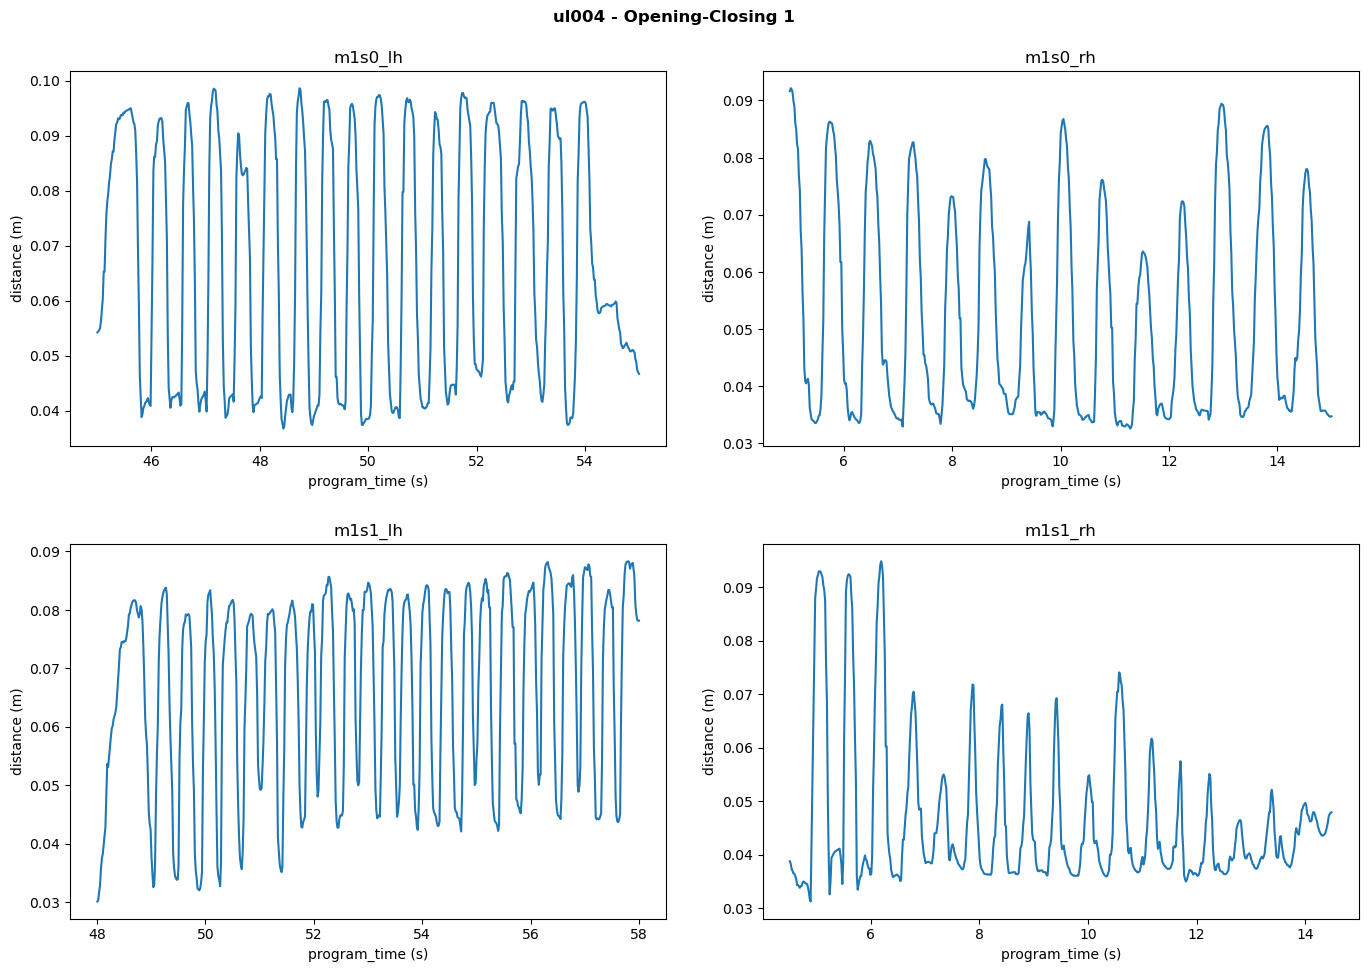

In [164]:
ls_dist_plt_1 = [df1_dist_lh_1, df1_dist_rh_1, df2_dist_lh_1, df2_dist_rh_1]
ls_fig_titles_dist_1 = ['m1s0_lh', 'm1s0_rh', 'm1s1_lh', 'm1s1_rh']
dir_fig_dist_1 = fig_dir[3]
plot_dist_1 = plot_mxsx('004', ls_dist_plt_1, ls_fig_titles_dist_1, dir_fig_dist_1, 'ul004_m1sX_vr_oc_1st_block')

Plotting second block

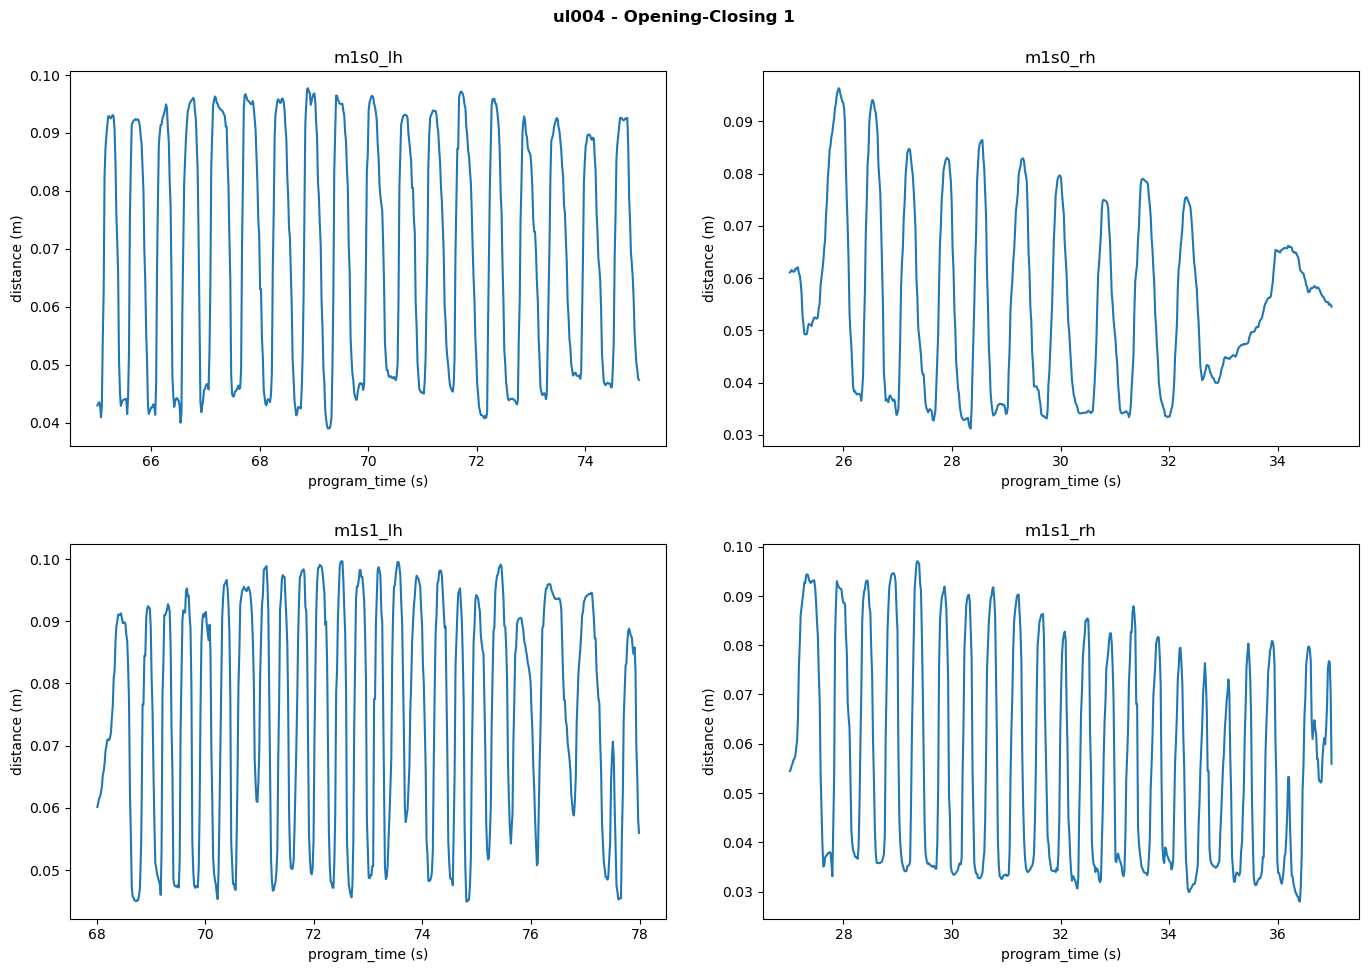

In [165]:
ls_dist_plt_2 = [df1_dist_lh_2, df1_dist_rh_2, df2_dist_lh_2, df2_dist_rh_2]
ls_fig_titles_dist_2 = ['m1s0_lh', 'm1s0_rh', 'm1s1_lh', 'm1s1_rh']
dir_fig_dist_2 = fig_dir[3]
plot_dist_2 = plot_mxsx('004', ls_dist_plt_2, ls_fig_titles_dist_2, dir_fig_dist_2, 'ul004_m1sX_vr_oc_2nd_block')


In [43]:
a = [4,5 , 7, 9, 1]

i = np.argmin(a)

a[i]

1

### Boxplot Function

In [73]:
def boxplots(ls_featname, xticklabels, ylabels, ls_feat1, ls_feat2, figdir, figname):

        boxplot_dict = {
        ls_featname[0]: ls_feat1,
        ls_featname[1]: ls_feat2
        }

     
        for n, feat in enumerate(ls_featname):

        #    axes[n].boxplot(feat_patients[feat].values.tolist())
            axes[n].boxplot(boxplot_dict[feat])
            axes[n].set_title(feat)
            axes[n].set_xticklabels(xticklabels)
            axes[n].set_ylabel(ylabels[n])
            # axes[n].set_xlabel()

        plt.tight_layout
        fig.savefig(
                    os.path.join(figdir, figname),
                    dpi = 300, facecolor = 'w',
                )
        plt.show()
        
        return

In [74]:
oc_list_to_plot = ['open_dist', 'speed_of_movement']
ylabels = ['distance (m)', 'speed (m/s)']#, 'Freq (Hz)']
xticklabels = ['StimOFF (Left) \n Score: 2', 'StimON (Left) \n Score: 2', 'StimOFF (Right) \n Score: 3', 'StimOn (Right) \n Score: 2.5']
ls_feat1 = [ampO_df1_dist_lh, ampO_df2_dist_lh, ampO_df1_dist_rh, ampO_df2_dist_rh]
ls_feat2 = [spe_df1_dist_lh, spe_df2_dist_lh, spe_df1_dist_rh, spe_df2_dist_rh]
figname = 'ul004_m1sX_vr_oc_dist_spe_boxplot'
fg_dir = fig_dir[3]
boxplots(oc_list_to_plot, xticklabels, ylabels, ls_feat1, ls_feat2, fg_dir, figname)

NameError: name 'ampO_df1_dist_lh' is not defined

Boxplots

In [56]:
boxplot_dict = {
    'open_dist': [ampO_df1_dist_lh, ampO_df2_dist_lh, ampO_df1_dist_rh, ampO_df2_dist_rh],
    'speed_of_movement': [spe_df1_dist_lh, spe_df2_dist_lh, spe_df1_dist_rh, spe_df2_dist_rh]
}

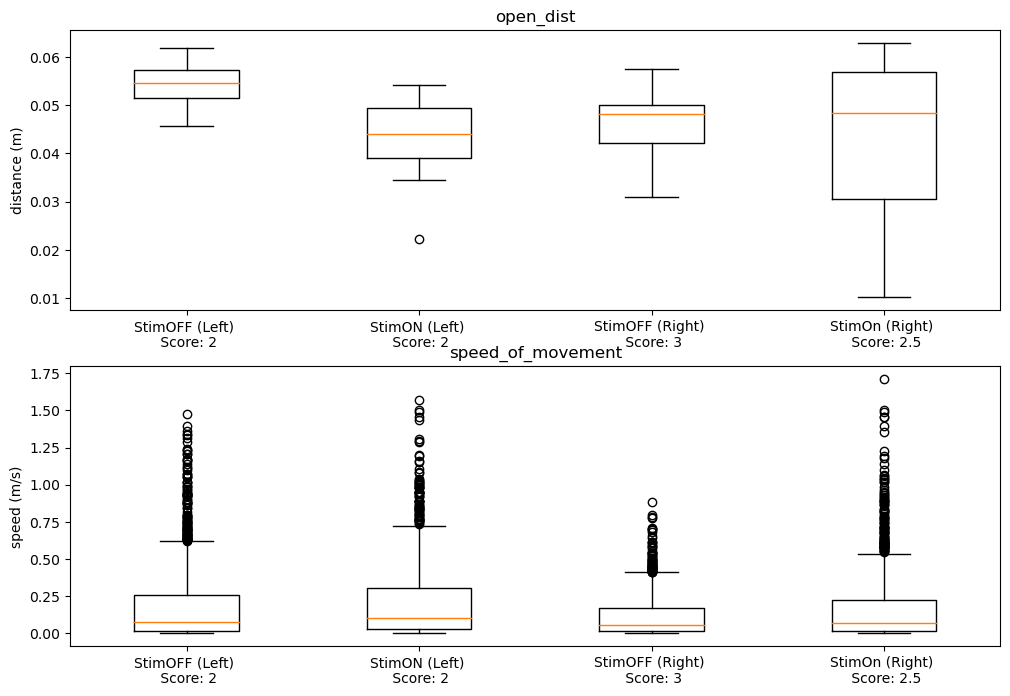

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

oc_list_to_plot = ['open_dist', 'speed_of_movement']#, 'mean_freq']
ylabels = ['distance (m)', 'speed (m/s)']#, 'Freq (Hz)']
xticklabels = ['StimOFF (Left) \n Score: 2', 'StimON (Left) \n Score: 2', 'StimOFF (Right) \n Score: 3', 'StimOn (Right) \n Score: 2.5']
for n, feat in enumerate(oc_list_to_plot):

#    axes[n].boxplot(feat_patients[feat].values.tolist())
    axes[n].boxplot(boxplot_dict[feat])
    axes[n].set_title(feat)
    axes[n].set_xticklabels(xticklabels)
    axes[n].set_ylabel(ylabels[n])
    # axes[n].set_xlabel()

plt.tight_layout
fig.savefig(
            os.path.join(fig_dir[3], 'ul004_m1sX_vr_oc_dist_spe_boxplot'),
            dpi = 300, facecolor = 'w',
        )
plt.show()

SPEED_OC NEW

In [134]:
def speed_OC_time_series(
    df,
    max_idx,
    min_idx
    ):

    """
    Calculates the speed of opening and closing.
    
    Input:
        - df (cleaned DataFrame), max_idx list, 
        min_idx list.
    
    Output:
        - dict: dictionary with pronation and 
        supination speeds.
    """

    speed_O = []
    speed_C = []

    for idx, (max, min) in enumerate(zip(max_idx, min_idx[:-1])):
        # max_idx[0] < min_idx[0] means that the patient started the exercise with pronation
        if max_idx[0] < min_idx[0]:
            
            max_dist_1 = df.iloc[max]['distance']
            max_dist_2 = df.iloc[max_idx[idx + 1]]['distance']
            max_time_1 = df.iloc[max]['program_time']
            max_time_2 = df.iloc[max_idx[idx + 1]]['program_time']

            min_dist_1 = df.iloc[min]['inv_distance']
            min_dist_2 = df.iloc[min_idx[idx+1]]['inv_distance']
            min_time_1 = df.iloc[min]['program_time']

            delta_dist_O = max_dist_2 - min_dist_1
            delta_time_O = max_time_2 - min_time_1

            delta_dist_C = min_dist_1 - max_dist_1
            delta_time_C = min_time_1 - max_time_1

            vel_O = delta_dist_O/delta_time_O
            vel_C = delta_dist_C/delta_time_C

            speed_O.append(vel_O)
            speed_C.append(vel_C)

        # max_idx[0] > min_idx[0] means that the patient started the exercise with supination
        # if max_idx[0] > min_idx[0]:
        else:
            max_dist_1 = df.iloc[max]['distance']
            max_time_1 = df.iloc[max]['program_time']

            min_dist_1 = df.iloc[min]['inv_distance']
            min_time_1 = df.iloc[min]['program_time']
            min_dist_2 = df.iloc[min_idx[idx + 1]]['inv_distance']
            min_time_2 = df.iloc[min_idx[idx + 1]]['program_time']

            delta_dist_O = max_dist_1 - min_dist_1
            delta_time_O = max_time_1 - min_time_1

            delta_dist_C = min_dist_2 - max_dist_1
            delta_time_C = min_time_2 - max_time_1

            vel_O = delta_dist_O/delta_time_O
            vel_C = delta_dist_C/delta_time_C

            speed_O.append(vel_O)
            speed_C.append(vel_C)
    dict = {'open_speed': speed_O,'close_speed': speed_C}
    return dict

ul001

In [135]:
dict1_speOC = speed_OC_time_series(
    df1_dist,
    df1_max, 
    df1_min
    )

Opening Maximum Speed

In [140]:
open_max_speed1 = np.max(dict1_speOC['open_speed'])
open_max_speed2 = np.max(dict2_speOC['open_speed'])
open_max_speed3 = np.max(dict3_speOC['open_speed'])
open_max_speed4 = np.max(dict4_speOC['open_speed'])
open_max_speed5 = np.max(dict5_speOC['open_speed'])

Opening Minimum Speed

In [38]:
open_min_speed = np.min(dict_speedOC['open_speed'])
open_min_speed

-0.6653132360268239

Opening Mean Speed

In [141]:
open_mean_speed1 = np.mean(dict1_speOC['open_speed'])
open_mean_speed2 = np.mean(dict2_speOC['open_speed'])
open_mean_speed3 = np.mean(dict3_speOC['open_speed'])
open_mean_speed4 = np.mean(dict4_speOC['open_speed'])
open_mean_speed5 = np.mean(dict5_speOC['open_speed'])

Opening Speed Standard Deviation

In [67]:
std_open_speed = np.std(dict_speedOC['open_speed'])
std_open_speed

0.46645459872192696

Closing Maximum Speed

In [40]:
close_max_speed = np.max(dict_speedOC['close_speed'])
close_max_speed

-0.13245781820408714

Closing Minimum Speed

In [41]:
close_min_speed = np.min(dict_speedOC['close_speed'])
close_min_speed

-1.1210171685324877

Closing Mean Speed

In [142]:
close_mean_speed1 = np.mean(dict1_speOC['open_speed'])
close_mean_speed2 = np.mean(dict2_speOC['open_speed'])
close_mean_speed3 = np.mean(dict3_speOC['open_speed'])
close_mean_speed4 = np.mean(dict4_speOC['open_speed'])
close_mean_speed5 = np.mean(dict5_speOC['open_speed'])

# Absolute Closing Speed
# abs(close_mean_speed)

Closing Speed Standard Deviation

In [68]:
std_close_speed = np.std(dict_speedOC['close_speed'])
std_close_speed

0.19848230559869912

Feature Extraction Function

In [44]:
def fts_ext():
    count_OC = len(min_idx_dist_df_003_M1S0_DT_oc_rh) # 1
    dict_freq_std = freq_tap(dist_df_003_M1S0_DT_oc_rh, min_idx_dist_df_003_M1S0_DT_oc_rh)
    std_freq = dict_freq_std['std_freq'] # 2
    mean_freq = np.mean(dict_freq_std['freq_per_tap']) # 3
    open_max_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 4
    open_min_amp = np.min(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 5
    open_mean_amp = np.mean(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 6
    open_std_amp = np.std(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 7
    close_max_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 8
    close_min_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 9
    close_mean_amp = np.mean(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 10
    close_std_amp = np.std(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance']) # 11
    open_max_speed = np.max(dict_speedOC['open_speed']) # 12
    open_min_speed = np.min(dict_speedOC['open_speed']) # 13
    open_mean_speed = np.mean(dict_speedOC['open_speed']) # 14
    std_open_speed = np.std(dict_speedOC['open_speed'])
    close_max_speed = np.max(dict_speedOC['close_speed']) # 15
    close_min_speed = np.min(dict_speedOC['close_speed']) # 16
    close_mean_speed = np.mean(dict_speedOC['close_speed']) # 17
    std_close_speed = np.std(dict_speedOC['close_speed'])

    return
    
    

Number of Opening-Closing events

In [45]:
count_OC = len(min_idx_dist_df_003_M1S0_DT_oc_rh)
count_OC

40

Frequency per Opening-Closing 

In [46]:
def freq_tap(df_time_amp, min_idx):

    freq_per_tap = []

    for idx, min in enumerate(min_idx[:-1]):

        min_time1 = df_time_amp.iloc[min]['program_time']
        min_time2 = df_time_amp.iloc[min_idx[idx+1]]['program_time']
   
        delta_time = min_time2-min_time1
        freq = 1/delta_time

        freq_per_tap.append(freq)
        # time_ls.append(delta_time)
    std_freq = np.std(freq_per_tap)

    dict_freq_std = {'std_freq': std_freq, 'freq_per_tap': freq_per_tap}

    return dict_freq_std

Opening-Closing Frequency Standard Deviation

In [47]:
dict_freq_std = freq_tap(dist_df_003_M1S0_DT_oc_rh, min_idx_dist_df_003_M1S0_DT_oc_rh)
std_freq = dict_freq_std['std_freq']
std_freq

0.49719821823963467

Opening-Closing Mean Frequency

In [48]:
mean_freq = np.mean(dict_freq_std['freq_per_tap'])
mean_freq

2.3205798012979177

Amplitude variability - CHECK

In [66]:
std_amp = np.std(dist_df_003_M1S0_DT_oc_rh['distance'])
std_amp

0.02664187996112638

### Minimum, Maximum & Mean Amplitudes

Opening Maximum Amplitude

In [50]:
open_max_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
open_max_amp

0.09702349020373532

Opening Minimum Amplitude

In [51]:
open_min_amp = np.min(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
open_min_amp

0.08452898724632002

Opening Mean Amplitude

In [52]:
open_mean_amp = np.mean(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
open_mean_amp

0.09332923883498252

Opening Standard Deviation

In [53]:
open_std_amp = np.std(dist_df_003_M1S0_DT_oc_rh.iloc[max_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
open_std_amp

0.002624456999687381

Closing Maximum Amplitude

In [54]:
close_max_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
close_max_amp

0.029703514481128332

Closing Minimum Amplitude

In [55]:
close_min_amp = np.max(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
close_min_amp

0.029703514481128332

Closing Mean Amplitude

In [56]:
close_mean_amp = np.mean(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
close_mean_amp

0.02901614388335062

Closing Standard Deviation

In [57]:
close_std_amp = np.std(dist_df_003_M1S0_DT_oc_rh.iloc[min_idx_dist_df_003_M1S0_DT_oc_rh]['distance'])
close_std_amp

0.0006246903890674014

Dictionary with features(#)

In [69]:
feature_set = {
    'num_events': count_OC, 
    'open_max_amp': open_max_amp, 
    'open_min_amp': open_min_amp,
    'open_mean_amp': open_mean_amp,
    'open_std_amp': open_std_amp,
    'close_max_amp': close_max_amp,
    'close_min_amp': close_min_amp,
    'close_mean_amp': close_mean_amp,
    'close_std_amp': close_std_amp,
    'open_max_speed': open_max_speed,
    'open_min_speed': open_min_speed,
    'open_mean_speed': open_mean_speed,
    'std_open_speed': std_open_speed,
    'close_max_speed': close_max_speed,
    'close_min_speed': close_min_speed,
    'close_mean_speed': close_mean_speed,
    'std_close_speed': std_close_speed,
    'mean_freq': mean_freq,
    'std_freq': std_freq,
    }

In [70]:
len(feature_set)

19

In [74]:
df_feature_set = pd.DataFrame(feature_set, index=['ul003'])
df_feature_set

,num_events,open_max_amp,open_min_amp,open_mean_amp,open_std_amp,close_max_amp,close_min_amp,close_mean_amp,close_std_amp,open_max_speed,open_min_speed,open_mean_speed,std_open_speed,close_max_speed,close_min_speed,close_mean_speed,std_close_speed,mean_freq,std_freq
ul003,40,0.097023,0.084529,0.093329,0.002624,0.029704,0.029704,0.029016,0.000625,1.022483,-0.665313,0.475712,0.466455,-0.132458,-1.121017,-0.489572,0.198482,2.32058,0.497198
